<a href="https://colab.research.google.com/github/williiiamr/Weather-Prediction/blob/master/Collab/Making_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import tensorflow as tf

In [ ]:
df = pd.read_excel('/content/cuaca_fix.xlsx', dtype={'Tanggal':str} , parse_dates=False)
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df.set_index('Tanggal', inplace=True)

In [ ]:
columns = ['MAX_TEMP', 'MIN_TEMP', 'SUNLIGHT', 'AVG_HUM', 'MAX_WINDSPEED', 'WINDIR']
df = df.drop(columns = columns)

In [ ]:
df.head()

,AVG_TEMP,RAINFALL,AVG_WINDSPEED
Tanggal,,,
2020-01-01,27.05,36.5,6.4
2020-01-02,27.90,0.0,5.8
2020-01-03,28.50,0.0,6.2
2020-01-04,29.05,0.0,7.9
2020-01-05,27.95,0.0,6.6


# Check Missing Values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2020-01-01 to 2023-12-31
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AVG_TEMP       1456 non-null   float64
 1   RAINFALL       1457 non-null   float64
 2   AVG_WINDSPEED  1456 non-null   float64
dtypes: float64(3)
memory usage: 45.7 KB


In [ ]:
df.isna().sum()

AVG_TEMP         5
RAINFALL         4
AVG_WINDSPEED    5
dtype: int64

In [ ]:
df.fillna(round(df.rolling(window=7, min_periods=1).mean(), 2), inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2020-01-01 to 2023-12-31
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AVG_TEMP       1461 non-null   float64
 1   RAINFALL       1461 non-null   float64
 2   AVG_WINDSPEED  1461 non-null   float64
dtypes: float64(3)
memory usage: 45.7 KB


# Feature Selection

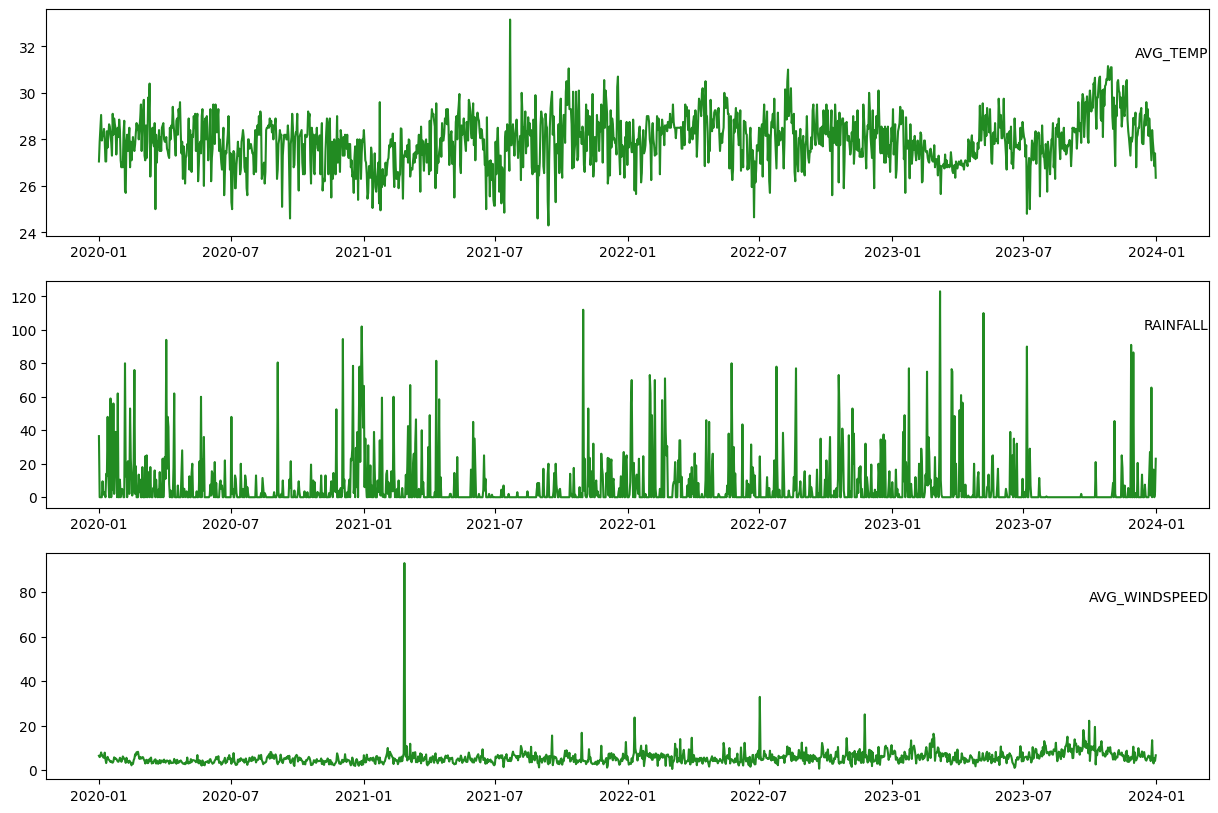

In [ ]:
i = 1
plt.figure(figsize=(15,10))
for column in df.columns:
  plt.subplot(len(df.columns), 1, i)
  plt.plot(df[column], c = "forestgreen")
  plt.title(column, y=0.75, loc='right', fontsize = 10)
  i += 1
plt.show()

## Alternative way to window dataset

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

In [ ]:
length = 7 # Length of the output sequences (in number of timesteps)
batch_size = 32 #Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_data, scaled_data, length=length, batch_size=batch_size, shuffle=False)

##Running Model

In [ ]:
n_steps = length
n_features = scaled_data.shape[1]

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(128, activation='relu', input_shape=(n_steps,n_features), return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(n_features)
])

In [ ]:
lr = 0.0001
loss = tf.keras.losses.Huber()
optimizer = tf.keras.optimizers.Adam(lr=lr)

model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
history = model.fit(generator, epochs=100)

Epoch 1/100
46/46 [==============================] - 3s 11ms/step - loss: 0.0083 - mae: 0.0833
Epoch 2/100
46/46 [==============================] - 1s 19ms/step - loss: 0.0058 - mae: 0.0712
Epoch 3/100
46/46 [==============================] - 1s 11ms/step - loss: 0.0055 - mae: 0.0676
Epoch 4/100
46/46 [==============================] - 1s 12ms/step - loss: 0.0055 - mae: 0.0670
Epoch 5/100
46/46 [==============================] - 1s 11ms/step - loss: 0.0052 - mae: 0.0646
Epoch 6/100
46/46 [==============================] - 1s 11ms/step - loss: 0.0052 - mae: 0.0640
Epoch 7/100
46/46 [==============================] - 1s 11ms/step - loss: 0.0052 - mae: 0.0643
Epoch 8/100
46/46 [==============================] - 1s 11ms/step - loss: 0.0051 - mae: 0.0627
Epoch 9/100
46/46 [==============================] - 1s 11ms/step - loss: 0.0051 - mae: 0.0637
Epoch 10/100
46/46 [==============================] - 1s 19ms/step - loss: 0.0050 - mae: 0.0617
Epoch 11/100
46/46 [=============================

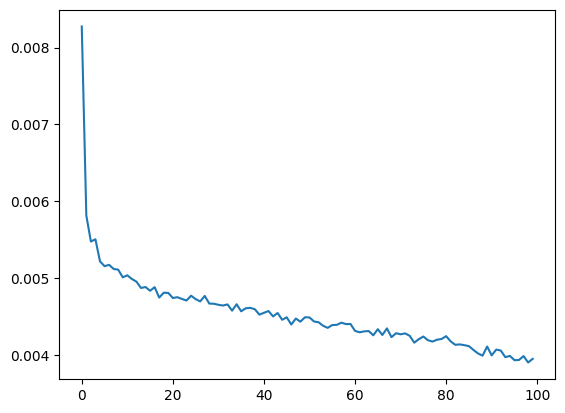

In [ ]:
plt.plot(history.history['loss'])
plt.show()

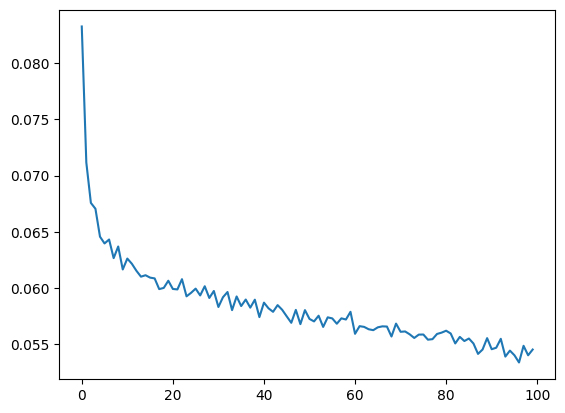

In [ ]:
plt.plot(history.history['mae'])
plt.show()

##Forecast

In [ ]:
import math
def round_decimal(lists):
  new_list = []
  for i in lists:
    if i < 0:
      i = 0
    else:
      i = math.floor(i*100)/100
    new_list.append(i)

  return new_list

In [ ]:
prediction_length = 7
n_features = scaled_data.shape[1]
test_predictions = []

first_eval_batch = scaled_data[-n_steps:]
current_batch = first_eval_batch.reshape((1, n_steps, n_features))

for i in range(prediction_length):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch, verbose=0)[0]

    # store prediction
    test_predictions.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
predictions = scaler.inverse_transform(test_predictions)

In [ ]:
true_predictions = np.array(list(map(round_decimal, predictions)))
prediksi = pd.DataFrame(true_predictions, columns=df.columns)
prediksi.index = pd.date_range(start='2024/01/01', end=f'2024/01/{prediction_length}', freq='D')

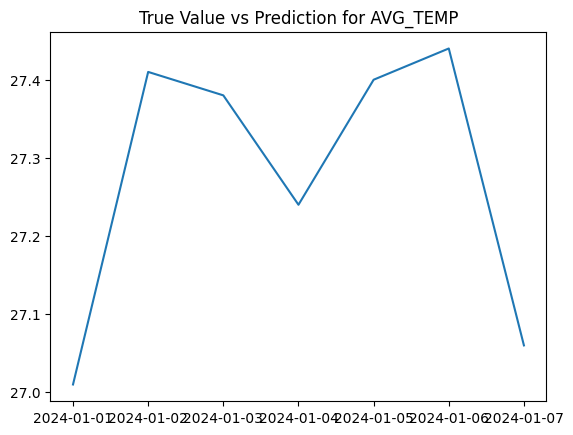

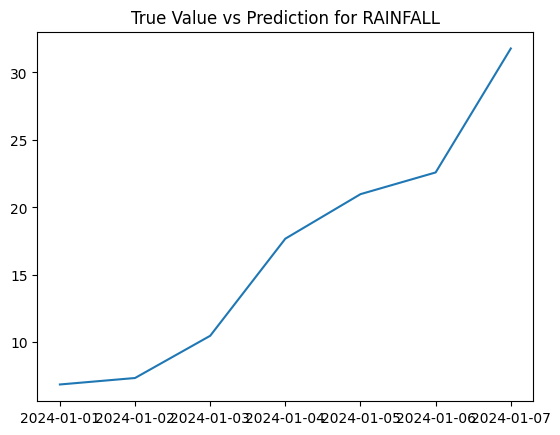

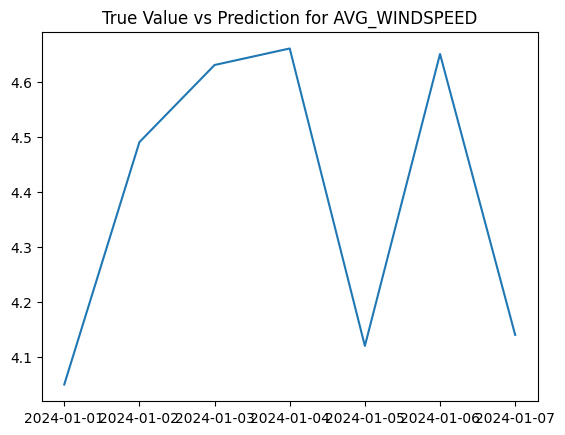

In [ ]:
variables_to_plot = list(df.columns)
for variable in variables_to_plot:
    plt.plot(prediksi.loc[:, [variable]])
    plt.title(f'True Value vs Prediction for {variable}')
    plt.show()


## Visualizing Forecast to whole data

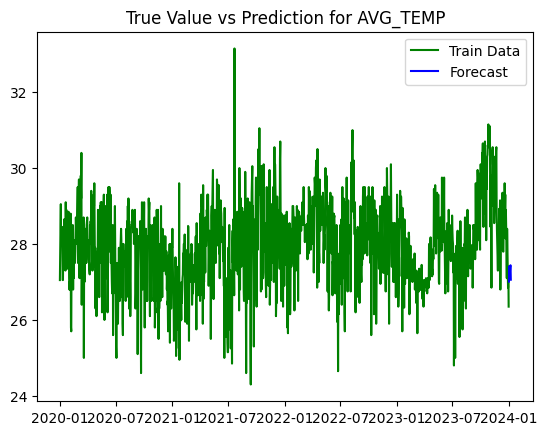

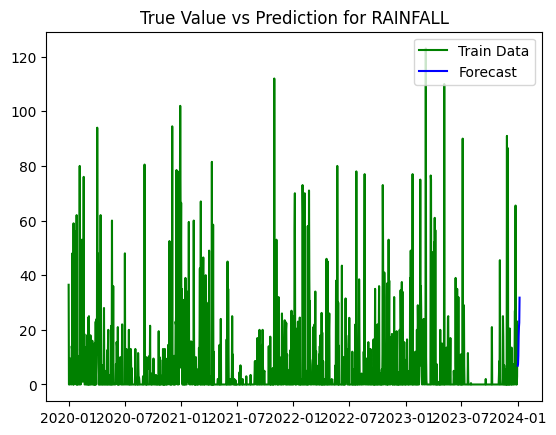

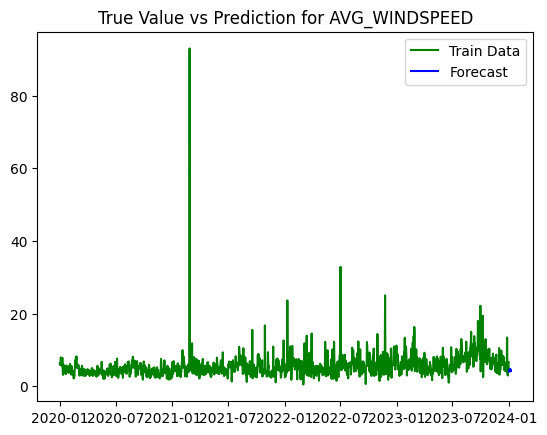

In [ ]:
variables_to_plot = list(df.columns)
for variable in variables_to_plot:
    plt.plot(df.loc[:, [variable]], color='green', label='Train Data')
    plt.plot(prediksi.loc[:, [variable]], color='blue', label='Forecast')
    plt.title(f'True Value vs Prediction for {variable}')
    plt.legend(loc='upper right')
    plt.show()


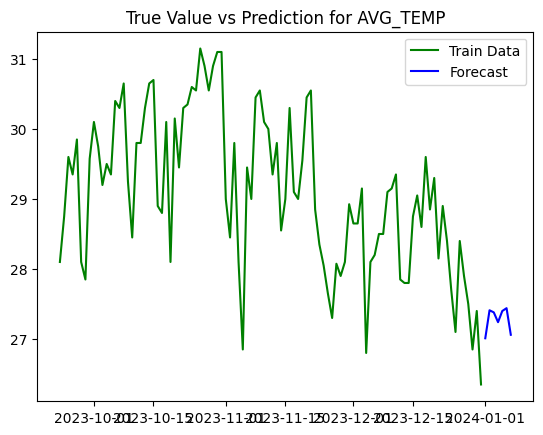

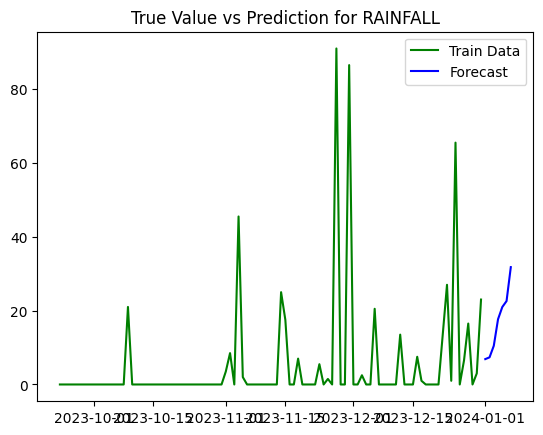

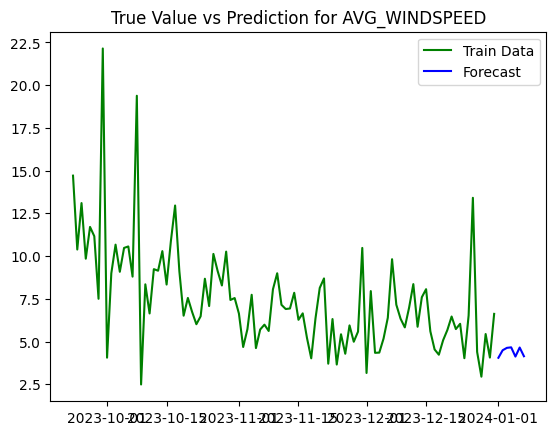

In [ ]:
variables_to_plot = list(df.columns)
df_last = df.iloc[-100:]
prediksi_last = prediksi.iloc[-100:]
for variable in variables_to_plot:
    plt.plot(df_last.loc[:, [variable]], color='green', label='Train Data')
    plt.plot(prediksi_last.loc[:, [variable]], color='blue', label='Forecast')
    plt.title(f'True Value vs Prediction for {variable}')
    plt.legend(loc='upper right')
    plt.show()

##Save Model

In [ ]:
model.save('model21.84rmse.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
